In [18]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import hypergeom

import os, glob

import matplotlib.pyplot as plt
import seaborn as sns

print(sc.__version__)
print(pd.__version__)
print(np.__version__)


1.5.2
1.1.3
1.19.2
0.11.0


In [2]:
# Some functions for gene enrichment analyses
def calculate_enrichment(hit_list, top_genes, full_gene_list):
    x = sum(pd.DataFrame(top_genes).isin(hit_list).values) # how many top genes in cell list
    n = sum(pd.DataFrame(hit_list).isin(full_gene_list).values)[0] # how many cell genes in full list
    N = len(top_genes)  # number of samples
    M = len(full_gene_list)  # total number in population

    enrichment = safe_div( (x/N) , ((n-x) / (M-N)) )
    p = hypergeom.sf(x-1, M, n, N)

    return enrichment, p

def safe_div(x,y):
    if y == 0:
        return np.array([0])
    return x / y

def run_enrichment(classes, gene_lists, positive_genes, negative_genes, background_genes):

    enrichment_results = []
    num_genes = []
    # for each cell class/type
    for i in np.arange(len(classes)):
        # calculate enrichment in the postively and negatively correlated lists
        for g in [positive_genes, negative_genes]:
            enrichment_results.append(calculate_enrichment(list(gene_lists[i]), list(g), list(background_genes)))
            num_genes.append(len(gene_lists[i]))

    # collate into dataframe
    results = pd.DataFrame(np.hstack(enrichment_results).T)
    results.columns=['enrichment', 'p']
    results['class'] = np.repeat(classes, 2)
    results['loading'] = ['positive', 'negative']*(len(classes))
    results['num_genes'] = np.squeeze(num_genes)
    results = results.loc[:,['class','loading','num_genes','enrichment','p']]

    return results

def run_enrichment_percentile(classes, gene_lists, test_genes, background_genes):

    enrichment_results = []
    num_genes = []
    # for each cell class/type
    for i in np.arange(len(classes)):
        # calculate enrichment in the postively and negatively correlated lists
        for g in test_genes:
            enrichment_results.append(calculate_enrichment(list(gene_lists[i]), list(g), list(background_genes)))
            num_genes.append(len(gene_lists[i]))

    # collate into dataframe
    results = pd.DataFrame(np.hstack(enrichment_results).T)
    results.columns=['enrichment', 'p']
    results['class'] = np.repeat(classes, 10)
    results['percentile'] = ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']*(len(classes))
    results['num_genes'] = np.squeeze(num_genes)
    results = results.loc[:,['class','percentile','num_genes','enrichment','p']]

    return results

# Gene enrichment analyses of PC1 genes
Neuronal cell types are distributed non-uniformly in the thalamus ([Jager et al., eLife, 2021](https://elifesciences.org/articles/59272); [Evangelio et al., Front Neuroanat, 2018](https://www.frontiersin.org/articles/10.3389/fnana.2018.00027/full) with distinct cellular subtypes differentiated by graded variations in gene expression both across and within discrete thalamic nuclei ([Philips et al., Nature Neuro, 2019](https://www.nature.com/articles/s41593-019-0483-3); [Li et al., Nature Neuro, 2020](https://www.nature.com/articles/s41586-020-2504-5); [Roy et al., Nature Neuro, 2022](https://www.nature.com/articles/s41593-021-00996-1.pdf)). 

To investigate potential associations between graded gene expression along PC1 and patterns of cellular diversity in the thalamus, we queried Drop-seq analysis of 89,027 cells in the adult mouse thalamus ([Saunders et al., Cell, 2018](https://www.cell.com/cell/pdf/S0092-8674(18)30955-3.pdf)) and tested if genes with expression that varies along the M-L axis were enriched for homologous thalamic cell type markers.

**Methods**  
Using the [DropViz](http://dropviz.org/) database, we downloaded lists of differentially expressed (DE) genes for eleven thalamic cell types:  
- neurons
- ependyma  
- astrocyte  
- polydendrocyte 
- endothelial 
- mural 
- fibroblast-like
- microglia/macrophage
- oligodendrocyte 

where cell types contained more than one subcluster (neuron, n=3; oligodendrocyte, n=2), they were combined into a single 'target' cluster and compared to all other cell types.

DE genes were defined using the following parameters:
- minimum fold ratio = 3
- maximum p-value exponent = -50
- minumum log expression in target = 1
- maximum mean expression in comparison = 6 (max value)

Gene homologs were identified using [Ensembl Biomart](https://www.ensembl.org/biomart) (reference genomes: human GRCh38.p13; mouse GRCm39). Gene lists were filtered to only include:
- genes with identified mouse-human homologs
- genes with protein expression in the human thalamus (list from [proteinatlas.org](https://www.proteinatlas.org/humanproteome/brain/thalamus)
- genes with expression in the top 75% based on aggregated UMI across cell types in the mouse thalamus

This ensures that corresponding genes are expressed in both the mouse and human thalamus.


In [3]:
# load Ensembl human-mouse genes
all_homologs = pd.read_csv('data/gene_data/gene_lists/mart_export.txt', delimiter='\t')

# load genes expressed in human thalamus and filter homologs
thalamus_proteins = pd.read_csv('data/gene_data/gene_lists/human_thalamus_protein.tsv', delimiter='\t', low_memory=False)
thalamus_proteins = thalamus_proteins['Gene']

all_homologs = all_homologs[all_homologs['Gene name'].isin(list(thalamus_proteins))]

# mouse genes with human homologs expressed in thalamus
mouse_homologs = all_homologs['Mouse gene name'].dropna()

# load genes assayed in Saunders et al (DropViz)
# this is a list of 'metacells' where each gene has a total count of transcripts for each cell cluster
# as many genes are assayed, but not all detected in the thalamus, we remove those with low UMI counts (<25%ile)
thalamic_cells = pd.read_csv('data/gene_data/gene_lists/DropViz.metacells.BrainCellAtlas_Saunders_version_2018.04.01.csv')
aggregated_UMI = thalamic_cells.loc[:,thalamic_cells.columns.str.contains('TH')].sum(axis=1)
thalamic_cells = thalamic_cells.loc[aggregated_UMI > np.percentile(aggregated_UMI, 25)]
# get list of genes
thalamic_cell_genes = thalamic_cells.iloc[:,0]

# filter to include only those with homologs expressed in human thalamus
thalamic_cell_genes = list(thalamic_cell_genes[thalamic_cell_genes.isin(mouse_homologs)])
print('The total number of background genes (measured in mouse thalamus using Drop-seq with human homologs also expressed in human thalamus):\n{:}'.format(len(thalamic_cell_genes)))

The total number of background genes (measured in mouse thalamus using Drop-seq with human homologs also expressed in human thalamus):
12787


# Over Representation Analysis
There are many (!) potential options for testing if one gene set is enriched for another. The simplest is Over-Representation Analysis (ORA) which uses the hypergeometric statistic / Fisher's exact test to test if more genes than expected are shared by both sets with respect to some background gene set. The background set should only include genes that have some chance of being selected in the test set (hence all the filtering above). Including genes that are expressed only in e.g.: muscle in the background set when testing brain-expressed genes will induce an optimistic bias in the [statistics](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0761-7).  

ORA requires:  
i) list of genes of interest (i.e.: top 100 DE genes from an analysis)  
ii) a test set (list of genes associated with a particular function/path/phenotype)  
iii) a background set (list of genes for comparison)  

In [4]:
# get cell type data
cell_data = pd.read_csv('data/gene_data/gene_lists/thalamus_cell_cluster_types.csv', delimiter='\t')
cell_data

,Region,Class,Cluster
0,Thalamus,Neuron,Neuron_Habenula_Tac2
1,Thalamus,Ependyma,Ependyma
2,Thalamus,Astrocyte,Astrocyte_Gja1
3,Thalamus,Polydendrocyte,Polydendrocyte_Tnr
4,Thalamus,Neuron,Neuron_Rora
5,Thalamus,Neuron,Neuron_Gad2-Ahi1
6,Thalamus,Endothelial,Endothelial_Flt1
7,Thalamus,Mural,Mural_Rgs5Acta2
8,Thalamus,Fibroblast-Like,Fibroblast-Like_Dcn
9,Thalamus,Microglia_Macrophage,Microglia_Macrophage_C1qb


In [5]:
# load differentially expressed gene lists from DropViz for each cell type
gene_lists = [list(pd.read_csv('data/gene_data/gene_lists/TH_' + cluster + '.csv')['gene']) for cluster in cell_data['Cluster']]

# filter out genes not included in the background set
filtered_gene_lists = [list(set(cluster_list) & set(thalamic_cell_genes)) for cluster_list in gene_lists]

# add to dataframe
cell_data['genes'] = filtered_gene_lists

#drop neuronal and oligodendrocyte subclusters for now
celltype_data = cell_data[~cell_data['Cluster'].isin(['Neuron_Habenula_Tac2', 'Neuron_Rora', 'Neuron_Gad2-Ahi1', 'Oligodendrocyte_Mbp', 'Oligodendrocyte_Tfr' ])]

# concatenate gene lists for each cell classes
cell_class = list(celltype_data.Class.unique())
cell_class_lists = [list(np.unique(np.concatenate(celltype_data[celltype_data['Class'] == cell]['genes'].values))) for cell in cell_class]

cell_class = [cell_class_.replace('Microglia_Macrophage','Microglia/Macrophage') for cell_class_ in cell_class]
print(cell_class)

print('Total number of DE genes per class after filtering\n')
for n,i in enumerate(cell_class):
    print('{:}: {:} genes'.format(i, len(cell_class_lists[n])))

['Ependyma', 'Astrocyte', 'Polydendrocyte', 'Endothelial', 'Mural', 'Fibroblast-Like', 'Microglia/Macrophage', 'Oligodendrocyte', 'Neuron']
Total number of DE genes per class after filtering

Ependyma: 626 genes
Astrocyte: 406 genes
Polydendrocyte: 221 genes
Endothelial: 775 genes
Mural: 512 genes
Fibroblast-Like: 265 genes
Microglia/Macrophage: 251 genes
Oligodendrocyte: 342 genes
Neuron: 1088 genes


The gene lists above are the gene sets that we are testing for enrichment in our PC-related genes. 
To collate the genes of interest, we:  
i) load the top/bottom 100 genes  
ii) identify the corresponding mouse homologs and  
iii) filter to remove any not included in the background set

In [6]:
OUTNAME='PC1'

# PC+ and PC- genes - change for the updated list of 100
# load top 100
positive_genes = pd.read_csv('data/processed/'+ OUTNAME + '_HumanMostPositiveSpinTested.csv', header=None)[0].values
# identify homologs
positive_homologs = all_homologs[all_homologs['Gene name'].isin(list(positive_genes))]['Mouse gene name'].dropna()
# remove any not in background
filtered_positive_homologs = list(set(positive_homologs) & set(thalamic_cell_genes))

print('From top {:} positive genes'.format(len(positive_genes)))
print('{:} corresponding mouse genes'.format(len(positive_homologs)))
print('with {:} in background set'.format(len(filtered_positive_homologs)))
print('')

# as above but for bottom 100
negative_genes = pd.read_csv('data/processed/'+ OUTNAME + '_HumanMostNegativeSpinTested.csv', header=None)[0].values
negative_homologs = all_homologs[all_homologs['Gene name'].isin(list(negative_genes))]['Mouse gene name'].dropna()
filtered_negative_homologs = list(set(negative_homologs) & set(thalamic_cell_genes))

print('From top {:} negative genes'.format(len(negative_genes)))
print('{:} corresponding mouse genes'.format(len(negative_homologs)))
print('with {:} in background set'.format(len(filtered_negative_homologs)))

From top 100 positive genes
95 corresponding mouse genes
with 93 in background set

From top 100 negative genes
87 corresponding mouse genes
with 85 in background set


## Calculate cell enrichment for each gene list
Enrichment is calculated based on the hypergeometric statistic. Uncorrected p-values are shown - consider FDR-correction.  

Results table shows:   
**class** - cell type  
**loading** - positive = top 100 genes, negative = bottom 100 genes  
**num_genes** - number of genes in the test set  
**enrichment ratio** - enrichment ratio in gene list vs background  
**p, p<0.01, etc** - uncorrected p-values  

In [7]:
enrichment = run_enrichment(cell_class, cell_class_lists, filtered_positive_homologs, filtered_negative_homologs, thalamic_cell_genes)
enrichment['p<0.01'] = enrichment['p']<0.01
enrichment['p<0.001'] = enrichment['p']<0.001
enrichment['p<0.0001'] = enrichment['p']<0.0001

enrichment

#enrichment.to_csv('data/processed/cell_enrichment/cell_enrichment_' + OUTNAME +'.csv')

,class,loading,num_genes,enrichment,p,p<0.01,p<0.001,p<0.0001
0,Ependyma,positive,626,0.000000,1.000000e+00,False,False,False
1,Ependyma,negative,626,5.957553,1.244669e-12,True,True,True
2,Astrocyte,positive,406,0.000000,1.000000e+00,False,False,False
3,Astrocyte,negative,406,3.387702,1.465248e-03,True,False,False
4,Polydendrocyte,positive,221,2.516030,7.742866e-02,False,False,False
5,Polydendrocyte,negative,221,0.679251,7.739153e-01,False,False,False
6,Endothelial,positive,775,0.000000,1.000000e+00,False,False,False
7,Endothelial,negative,775,0.193069,9.951682e-01,False,False,False
8,Mural,positive,512,0.000000,1.000000e+00,False,False,False
9,Mural,negative,512,0.000000,1.000000e+00,False,False,False


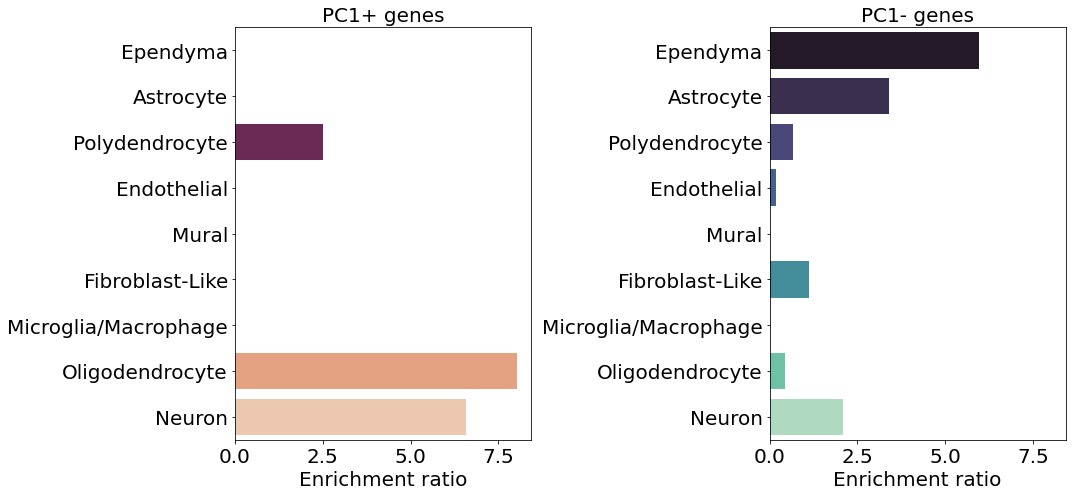

In [8]:
# plot
# positive and negative cell enrichments
positive_enrichment = enrichment.loc[enrichment.loading=='positive']
negative_enrichment = enrichment.loc[enrichment.loading=='negative']

# plot enrichments
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7), sharey=False, sharex=True)

sns.barplot(y='class', x='enrichment', hue='class', palette='rocket', data=positive_enrichment,
            dodge=False, ax=ax1, orient='h')

sns.barplot(y='class', x='enrichment', hue='class', palette='mako', data=negative_enrichment,
            dodge=False, ax=ax2, orient='h')

for ax in [ax1,ax2]:
    ax.legend().set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('')
    ax.set_xlabel('Enrichment ratio', fontsize=20)
ax1.set_title('PC1+ genes', fontsize=20)
ax2.set_title('PC1- genes', fontsize=20)

plt.tight_layout()


Significant enrichment for oligodendroctes (and polydendrocytes ~oligo precursors) cells in positive (lateral) genes.  

Significant enrichment for glial and ependymal cells in negative (medial) genes (makes sense given position and proximity to ventricles) - aso derived from radial glia which may explain why we see enrichment in fetal period.

Neurons are enriched for both positive and negative types. See below for an analysis of neuronal subtypes.

In [9]:
# repeat the enrichment analysis focusing on neuronal subtypes
neuron_cell_data = cell_data[cell_data['Class'] == 'Neuron']
# drop whole neuron group
neuron_cell_data = neuron_cell_data.loc[~(neuron_cell_data['Cluster']=='Neuron_ALL')]
neuron_cell_data

,Region,Class,Cluster,genes
0,Thalamus,Neuron,Neuron_Habenula_Tac2,"[Pcbd1, Hap1, Lrrn3, Tac1, Eno1, Gfra1, Dpp6, ..."
4,Thalamus,Neuron,Neuron_Rora,"[Syngr3, Rnf150, Vipr2, Pgm2l1, Nt5dc3, Zmat4,..."
5,Thalamus,Neuron,Neuron_Gad2-Ahi1,"[Sipa1l1, Hap1, Dlk1, Grin3a, Slc12a5, Pygo1, ..."


In [10]:
# subtype enrichment

#neuron_clusters_orig = list(neuron_cell_data['Cluster'])

#neuron_cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3']
neuron_cluster_names = ['Habenula', 'Rora', 'Gad2/Ahi1']

neuron_enrichment = run_enrichment(neuron_cluster_names, list(neuron_cell_data['genes']), filtered_positive_homologs, filtered_negative_homologs, thalamic_cell_genes)
neuron_enrichment['p<0.01'] = neuron_enrichment['p']<0.01
neuron_enrichment['p<0.001'] = neuron_enrichment['p']<0.001
neuron_enrichment['p<0.0001'] = neuron_enrichment['p']<0.0001
neuron_enrichment

#neuron_enrichment.to_csv('data/processed/cell_enrichment/neuron_enrichment_' + OUTNAME +'.csv')

,class,loading,num_genes,enrichment,p,p<0.01,p<0.001,p<0.0001
0,Habenula,positive,294,0.465852,8.859527e-01,False,False,False
1,Habenula,negative,294,5.808439,3.705692e-06,True,True,True
2,Rora,positive,672,8.638900,5.180494e-27,True,True,True
3,Rora,negative,672,1.346264,2.885812e-01,False,False,False
4,Gad2/Ahi1,positive,231,1.795982,2.364162e-01,False,False,False
5,Gad2/Ahi1,negative,231,8.188235,3.733730e-08,True,True,True


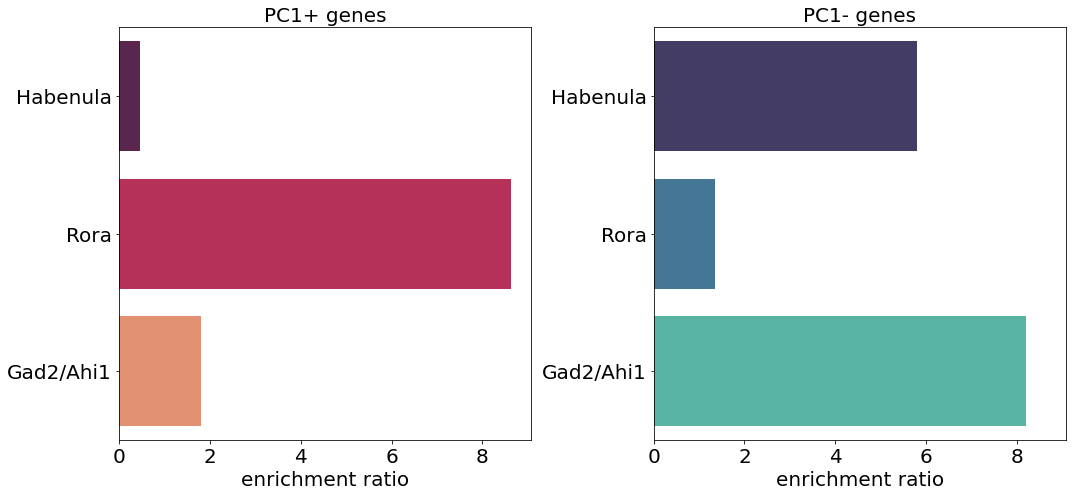

In [11]:
# positive and negative cell enrichments
positive_neuron_enrichment = neuron_enrichment.loc[neuron_enrichment.loading=='positive']
negative_neuron_enrichment = neuron_enrichment.loc[neuron_enrichment.loading=='negative']

# plot enrichments
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7), sharey=False, sharex=True)
sns.barplot(y='class', x='enrichment', hue='class', palette='rocket', data=positive_neuron_enrichment,
            dodge=False, ax=ax1, orient='h')

sns.barplot(y='class', x='enrichment', hue='class', palette='mako', data=negative_neuron_enrichment,
            dodge=False, ax=ax2, orient='h')

for ax in [ax1,ax2]:
    ax.legend().set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('')
    ax.set_xlabel('enrichment ratio', fontsize=20)
ax1.set_title(OUTNAME+'+ genes', fontsize=20)
ax2.set_title(OUTNAME+'- genes', fontsize=20)

plt.tight_layout()

Clear differentiation in neuronal cell types across M-L axis  

Based on Saunders et al:  
*Neuron_Rora* is a cluster of ~10 subtypes of excitatory neurons expressing SLC17a6  
*Neuron_Gad2-Ahi1* is a cluster of ~11 subtypes of neurons most expressing GAD1 and GAD2 (GABAergic/inhibitory)  
*Neuron_Habenula_Tac2* are cholinergic and glutamatergic neurons in the habenula (dorsomedial, posterior thalamus) 

In [12]:
for n, i in enumerate(list(neuron_cell_data['Cluster'])):
    print('')
    print('genes shared between postive top 100 and {:}'.format(i))
    print(list(set(filtered_positive_homologs) & set(list(neuron_cell_data['genes'])[n])))
    save_name=format(i)
    genelist=pd.DataFrame({'Gene' : list(set(filtered_positive_homologs) & set(list(neuron_cell_data['genes'])[n]))})
    #genelist.to_csv('data/processed/cell_enrichment/Positive'+save_name+'Genes_' + OUTNAME +'.csv')


genes shared between postive top 100 and Neuron_Habenula_Tac2
['Hhip']

genes shared between postive top 100 and Neuron_Rora
['Slc24a2', 'Rnf157', 'Nat8l', 'Gabrb2', 'Zmat4', 'Ypel4', 'Cttnbp2', 'Fstl4', 'Gnal', 'Scn1b', 'Scn8a', 'Diras1', 'Il1rapl1', 'Lrtm2', 'Cplx1', 'Grm1', 'Adcy1', 'Tmem38a', 'Adarb2', 'Kcnc1', 'Kcna2', 'Grid1', 'Grm4', 'Cacng2', 'Sncb', 'Fndc5', 'Cux2', 'Paqr9', 'Myo5a', 'Krt222', 'Gabbr2', 'Rgs7bp', 'Rasgrf1', 'Adam23', 'Snph', 'Ckmt1', 'Adam11', 'Atp2b2', 'Hspa12a', 'Atp1a3']

genes shared between postive top 100 and Neuron_Gad2-Ahi1
['Pvalb', 'Rasgrf1', 'Atp1a3']


In [13]:
for n, i in enumerate(list(neuron_cell_data['Cluster'])):
    print('')
    print('genes shared between negative bottom 100 and {:}'.format(i))
    print(list(set(filtered_negative_homologs) & set(list(neuron_cell_data['genes'])[n])))
    save_name=format(i)
    genelist=pd.DataFrame({'Gene' : list(set(filtered_negative_homologs) & set(list(neuron_cell_data['genes'])[n]))})
    #genelist.to_csv('data/processed/cell_enrichment/Negative'+save_name+'Genes_' + OUTNAME +'.csv')


genes shared between negative bottom 100 and Neuron_Habenula_Tac2
['Ngb', 'Vat1l', 'Itm2c', 'Syt10', 'Zcchc12', 'Scn3a', 'Pkia', 'Zcchc18', 'Mgat4c', 'Cnr1', 'Syt4']

genes shared between negative bottom 100 and Neuron_Rora
['Gabrb1', 'Gpr12', 'Reep1', 'Panx2', 'Disp2', 'Syt4']

genes shared between negative bottom 100 and Neuron_Gad2-Ahi1
['Vat1l', 'Htr2c', 'Gng4', 'Zcchc12', 'Plcxd3', 'Disp2', 'Scn3a', 'Pkia', 'Dlx1', 'Zcchc18', 'Gda', 'Cnr1']


DLX1 is an GABAergic interneuron marker; GNG4 shows enhanced inhibitory neuron expression; others are expressed by both excit and inhib neurons: Cnr1; Gda; Scn3a

## Subcluster analysis  
Based on pattern of enrichment above, a set of genes expressed by distinct neuronal clusters are differentially expressed along the primary axis. In Saunders et al, the authors make a point that the subclusters all lie near each other in a low-dim space and therefore display similar gene expression profiles compred to other cell types. This also suggests that cell types near the 'border' of adjacent clusters themselves have similar gene expression to each other - this matches observations from Philips et al that cells at the borders of thalamuc nuclei share many properties and are not distinct populations. This suggests that there may be a graded enrichment of genes across subclusters with certain cell types sharing more enrich genes than others, rather than forming discrete clusters with or without enrichment. 

To test, we repeat the enrichment analysis but focusing on neuronal cell subclusters (n=25). Enrichment was defined using same criteria as above but within subclusters. Only neurons outside of subtype were included in reference set i.e.: subcluster 1-1 vs 2-1+2-2+...+3-1+3-2+...+3-11   but not 1-2, 1-3, 1-4.  

Background set was defined as all genes expressed by neurons (http://dropviz.org/?_state_id_=ea878c502fb5eb78) min fold ratio 1, no p-value limit, min mean amount = 1

In [14]:
# gene lists for each neuronal subcluster
cluster_lists =  sorted(glob.glob('data/gene_data/gene_lists/subclusters/*csv'))
#print(cluster_lists)
# name for each cluster
cluster_names = [('Cluster '+ s.split('\\')[-1].split('.')[0]) for s in cluster_lists]

cluster_names = [cluster_name.replace('Cluster 1','Habenula').replace('Cluster 2','Rora').replace('Cluster 3','Gad2/Ahi1') for cluster_name in cluster_names]
print(cluster_names)
# get cluster genes
cluster_genes = [list(pd.read_csv(s)['gene']) for s in cluster_lists]

# filter out genes not included in thalamic background
filtered_cluster_genes = [list(set(s) & set(thalamic_cell_genes)) for s in cluster_genes]

# all genes expressed by neuron class
neuron_genes = pd.read_csv('data/gene_data/gene_lists/all-neuronal-genes.csv')['gene']
# filter out any not in thalamic background
neuron_genes = neuron_genes[neuron_genes.isin(thalamic_cell_genes)]


['Habenula-1', 'Habenula-2', 'Habenula-3', 'Habenula-4', 'Rora-1', 'Rora-10', 'Rora-11', 'Rora-2', 'Rora-3', 'Rora-4', 'Rora-5', 'Rora-6', 'Rora-7', 'Rora-8', 'Rora-9', 'Gad2/Ahi1-1', 'Gad2/Ahi1-10', 'Gad2/Ahi1-11', 'Gad2/Ahi1-2', 'Gad2/Ahi1-3', 'Gad2/Ahi1-4', 'Gad2/Ahi1-5', 'Gad2/Ahi1-6', 'Gad2/Ahi1-7', 'Gad2/Ahi1-8', 'Gad2/Ahi1-9']


In [15]:
subcluster_enrichment = run_enrichment(cluster_names, cluster_genes, filtered_positive_homologs, filtered_negative_homologs, neuron_genes)
subcluster_enrichment.rename(columns={"class": "subcluster"}, inplace=True)
subcluster_enrichment

#subcluster_enrichment.to_csv('data/processed/cell_enrichment/subcluster_enrichment_' + OUTNAME +'.csv')

,subcluster,loading,num_genes,enrichment,p
0,Habenula-1,positive,133,0.944564,6.589568e-01
1,Habenula-1,negative,133,2.118182,2.516113e-01
2,Habenula-2,positive,214,0.708423,7.605093e-01
3,Habenula-2,negative,214,4.160714,8.596835e-03
4,Habenula-3,positive,246,0.685571,7.715585e-01
5,Habenula-3,negative,246,4.905263,1.876395e-03
6,Habenula-4,positive,22,0.000000,1.000000e+00
7,Habenula-4,negative,22,3.883333,2.415159e-01
8,Rora-1,positive,147,2.277074,5.285481e-02
9,Rora-1,negative,147,0.000000,1.000000e+00


In [16]:
# split into positive and negative lists
positive_subcluster_enrichment = subcluster_enrichment.loc[subcluster_enrichment.loading=='positive'].copy().reset_index(drop=True)
negative_subcluster_enrichment = subcluster_enrichment.loc[subcluster_enrichment.loading=='negative'].copy().reset_index(drop=True)
print(negative_subcluster_enrichment)

#print(positive_subcluster_enrichment)
# sort by total amount of enrichment
positive_subcluster_enrichment['total_enrichment'] = positive_subcluster_enrichment['enrichment'] - negative_subcluster_enrichment['enrichment']
negative_subcluster_enrichment['total_enrichment'] = positive_subcluster_enrichment['enrichment'] - negative_subcluster_enrichment['enrichment'] 

positive_subcluster_enrichment = positive_subcluster_enrichment.sort_values(by='total_enrichment')
negative_subcluster_enrichment = negative_subcluster_enrichment.sort_values(by='total_enrichment')

# negate negative enrichment to plot
negative_subcluster_enrichment['negative_enrichment'] = negative_subcluster_enrichment['enrichment']*-1


      subcluster   loading  num_genes  enrichment         p
0     Habenula-1  negative        133    2.118182  0.251611
1     Habenula-2  negative        214    4.160714  0.008597
2     Habenula-3  negative        246    4.905263  0.001876
3     Habenula-4  negative         22    3.883333  0.241516
4         Rora-1  negative        147    0.000000  1.000000
5        Rora-10  negative        235    0.258889  0.980398
6        Rora-11  negative        236    0.260335  0.979957
7         Rora-2  negative        141    0.435514  0.902147
8         Rora-3  negative        150    0.000000  1.000000
9         Rora-4  negative        146    0.427523  0.906326
10        Rora-5  negative         39    0.000000  1.000000
11        Rora-6  negative        163    0.000000  1.000000
12        Rora-7  negative         79    0.000000  1.000000
13        Rora-8  negative        199    0.000000  1.000000
14        Rora-9  negative        196    0.291250  0.969456
15   Gad2/Ahi1-1  negative        101   

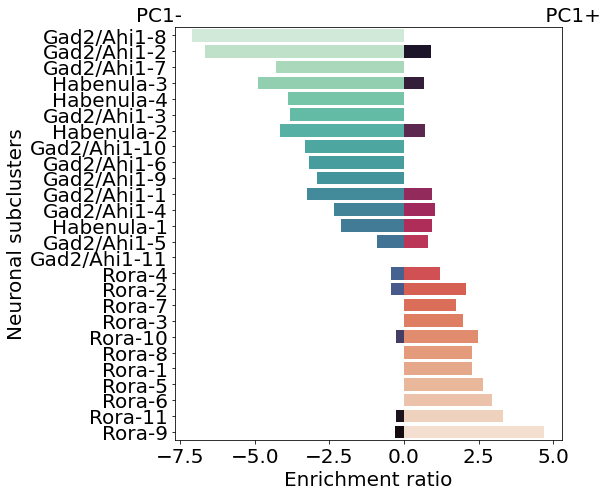

In [17]:
# plot enrichments
fig, ax1 = plt.subplots(1,1, figsize=(8,7), sharey=False, sharex=True)


sns.barplot(y='subcluster', x='negative_enrichment', hue='subcluster', palette='mako_r', data=negative_subcluster_enrichment,
            dodge=False, ax=ax1, orient='h')
sns.barplot(y='subcluster', x='enrichment', hue='subcluster', palette='rocket', data=positive_subcluster_enrichment,
            dodge=False, ax=ax1, orient='h')


for ax in [ax1]:
    ax.legend().set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('Neuronal subclusters', fontsize=20)
    ax.set_xlabel('Enrichment ratio', fontsize=20)
ax1.set_title(OUTNAME+'-                                                         '+OUTNAME+'+', fontsize=20)

plt.tight_layout()

This might need a bit more exploration. In particular identifying the genes that are shared by the cell types at the top and bottom of the gradient. 

I think next step would be to map the expression of several known inhib and exhib markers and correlation to the M-L gradient.